# Analyze Baselines

In [54]:
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

## Helper Functions

### Metrics

In [55]:
def is_hard_violation(row, phase_start):
    pred_phase = row['y_pred']
    t = row['t_rel']

    if pred_phase == 0:
        return False

    for prev_p in range(1, pred_phase):
        if prev_p in phase_start:
            if t < phase_start[prev_p]:
                return True

    return False

In [56]:
def is_soft_violation(row, phase_start):
    pred_phase = row['y_pred']
    t = row['t_rel']

    if pred_phase == 0:
        return False

    next_phase = pred_phase + 1

    if next_phase in phase_start:
        if t >= phase_start[next_phase]:
            return True

    return False

In [57]:
def mis_metrics(mis_df, phase_start):
    
    mis_df['hard_violation'] = mis_df.apply(
        is_hard_violation,
        axis=1,
        phase_start=phase_start
    )

    mis_df['soft_violation'] = mis_df.apply(
        is_soft_violation,
        axis=1,
        phase_start=phase_start
    )

    wrong = mis_df[mis_df['phase'] != mis_df['y_pred']]

    hard = wrong[wrong['hard_violation']]
    soft = wrong[(~wrong['hard_violation']) & (wrong['soft_violation'])]
    plausible = wrong[(~wrong['hard_violation']) & (~wrong['soft_violation'])]

    return wrong, hard, soft, plausible

### Plots

In [58]:
def plot_mis_predictions(df, phase_bounds, plausible, soft, hard, total_wrong, soft_rate, hard_rate, exp_name):
    
    plt.figure(figsize=(14, 5))

    # --- True phase over time ---
    plt.plot(
        df['t_rel'],
        df['phase'],
        color='black',
        linewidth=1,
        alpha=0.3,
        label="True phase"
    )

    # --- Shaded phase intervals ---
    for phase, bounds in phase_bounds.iterrows():
        plt.axvspan(
            bounds['min'],
            bounds['max'],
            alpha=0.05
        )

    # --- Plausible errors ---
    plt.scatter(
        plausible['t_rel'],
        plausible['y_pred'],
        s=60,
        alpha=0.8,
        label='Wrong but temporally plausible'
    )

    # --- Soft violations ---
    plt.scatter(
        soft['t_rel'],
        soft['y_pred'],
        s=70,
        marker='s',
        alpha=0.9,
        label='Soft violation (phase regression)'
    )

    # --- Hard violations ---
    plt.scatter(
        hard['t_rel'],
        hard['y_pred'],
        s=90,
        marker='X',
        edgecolor='black',
        linewidth=0.6,
        zorder=3,
        label='Hard violation (causal impossibility)'
    )

    # --- Cosmetics ---
    plt.xlabel("Relative time")
    plt.ylabel("Phase")
    plt.title(f"Temporal Consistency: {exp_name}")

    plt.yticks(sorted(df['phase'].unique()))
    plt.grid(alpha=0.2)

    plt.text(
        0.02,
        0.95,
        f"Total wrong: {total_wrong}\n"
        f"Hard: {len(hard)} ({hard_rate:.2%})\n"
        f"Soft: {len(soft)} ({soft_rate:.2%})",
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )

    plt.legend(frameon=False)
    plt.tight_layout()

    # Save to file
    out_path = f"../reports/baselines/{exp_name}_temp_plot.png" 
    plt.savefig(out_path)

    plt.show()

## Load Original Flows

In [59]:
# Configuration
dataset = "darpa2000"
scenario = "s1_inside"

In [60]:
df = pd.read_csv(
    f"../data/interim/{dataset}/{scenario}/flows_labeled/all_flows_labeled.csv"
)

df = df.sort_values("start_time").reset_index(drop=True)
df['t_rel'] = df['start_time'] - df['start_time'].min()

In [61]:
phase_bounds = (
    df[df['phase'] > 0]
    .groupby('phase')['t_rel']
    .agg(['min', 'max'])
)

phase_start = phase_bounds['min'].to_dict()
phase_end   = phase_bounds['max'].to_dict()

In [62]:
phase_bounds

,min,max
phase,,
1,1799.665435,1824.341042
2,2790.877254,3333.974143
3,4294.134775,4402.837414
4,5305.272464,5357.444592
5,7478.960660,8383.254878


## Compute Custom Metrics for All Models

In [63]:
import os
import json
import pandas as pd
from itertools import product

results = []

In [64]:
models = [
    "multi_class_lstm",
    "ensemble_lstm",
]

window_sizes = [10, 50, 100]
resampled_opts = ["original", "resampled"]
class_weight_opts = ["no_class_weights", "class_weights"]

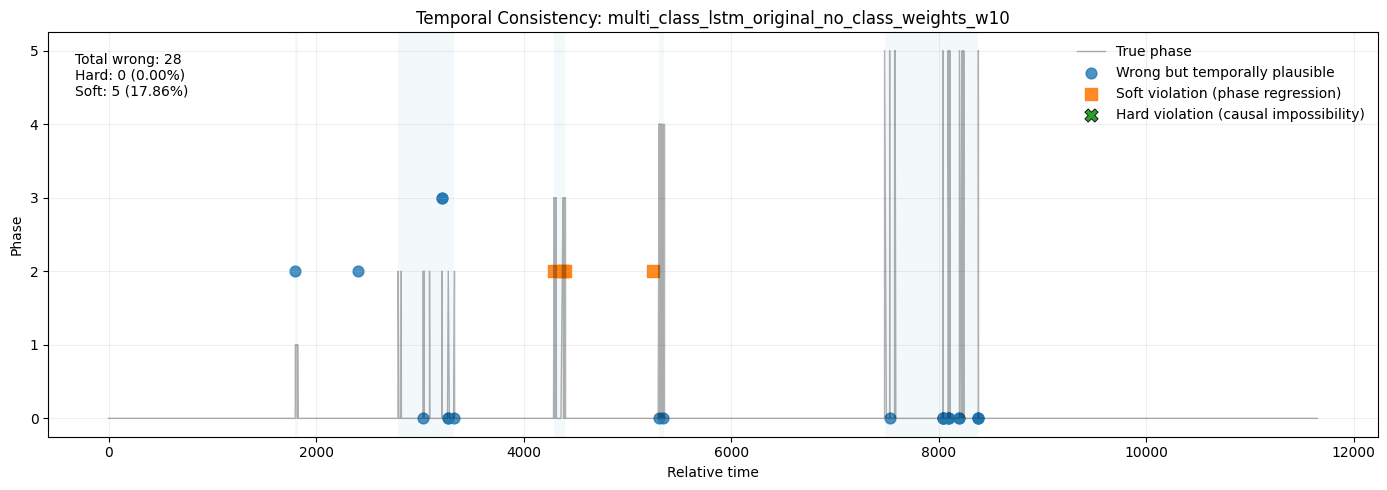

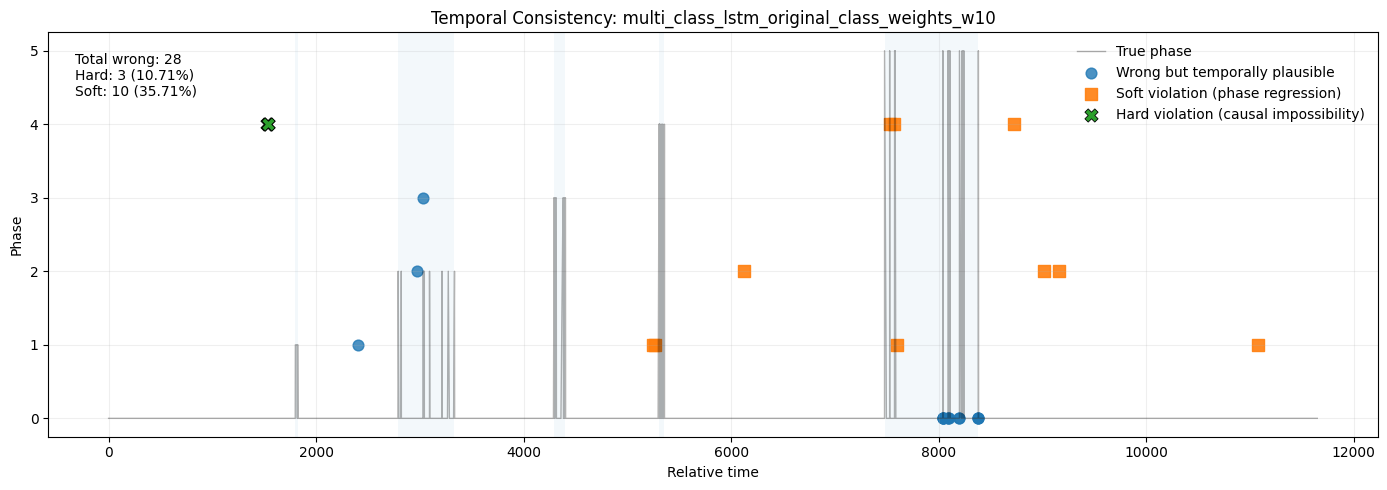

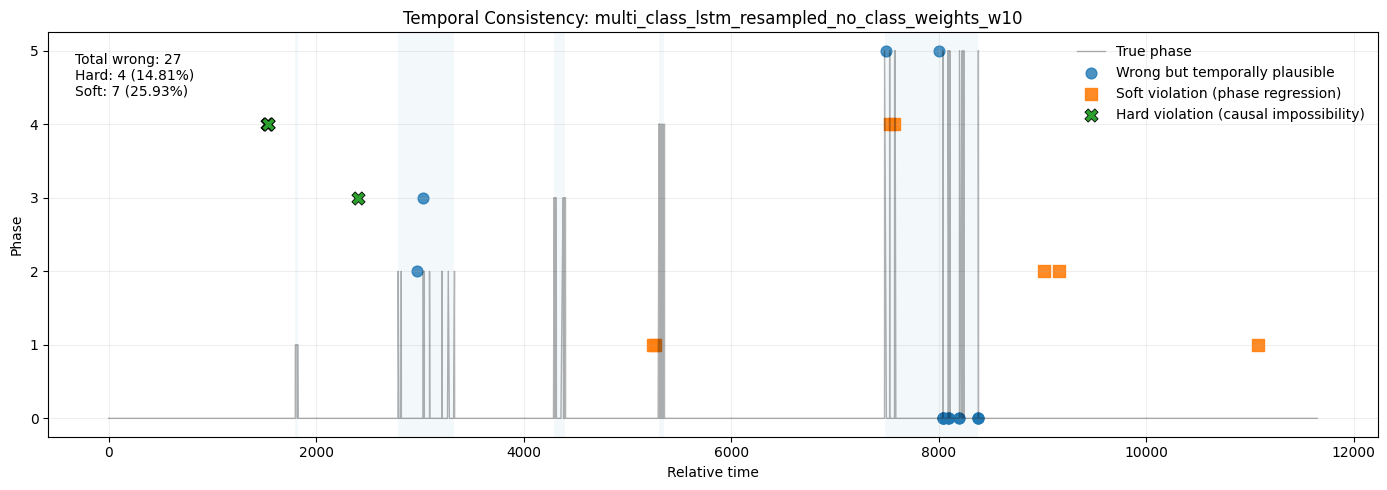

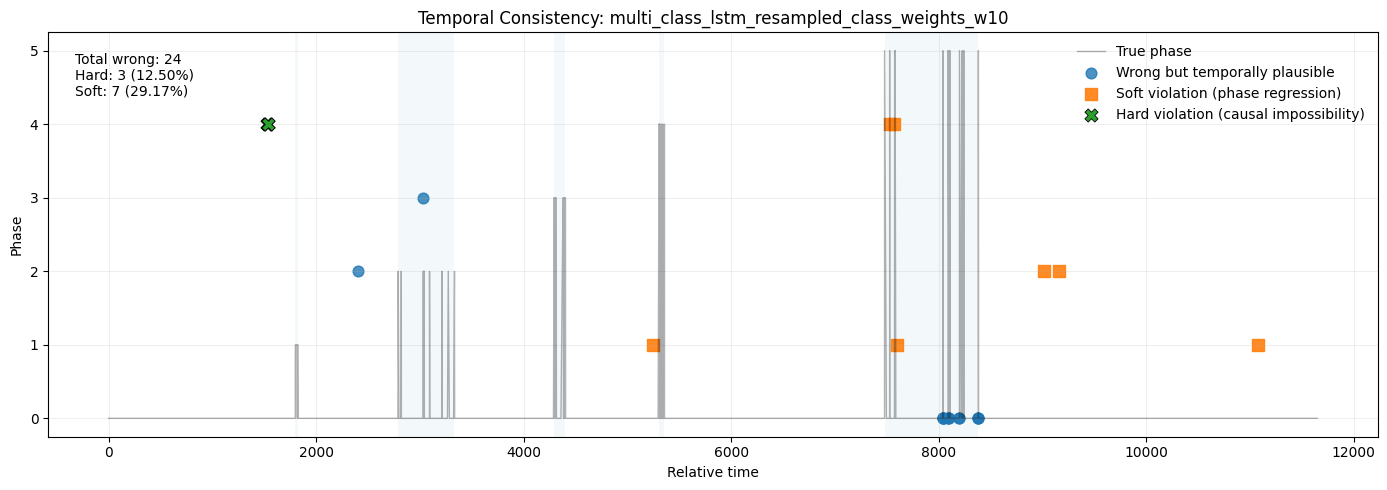

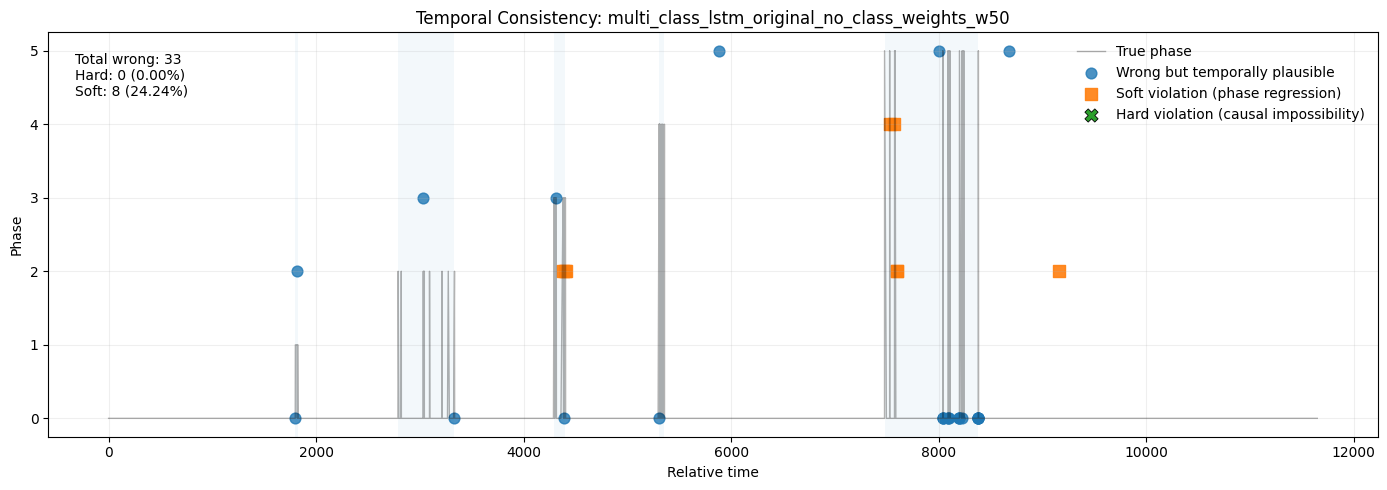

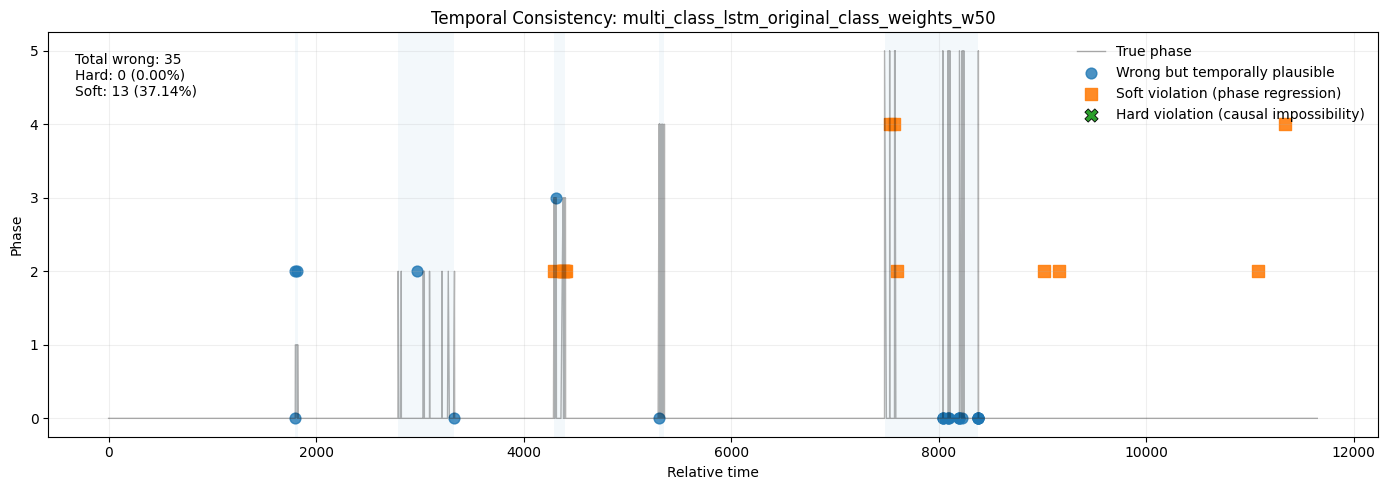

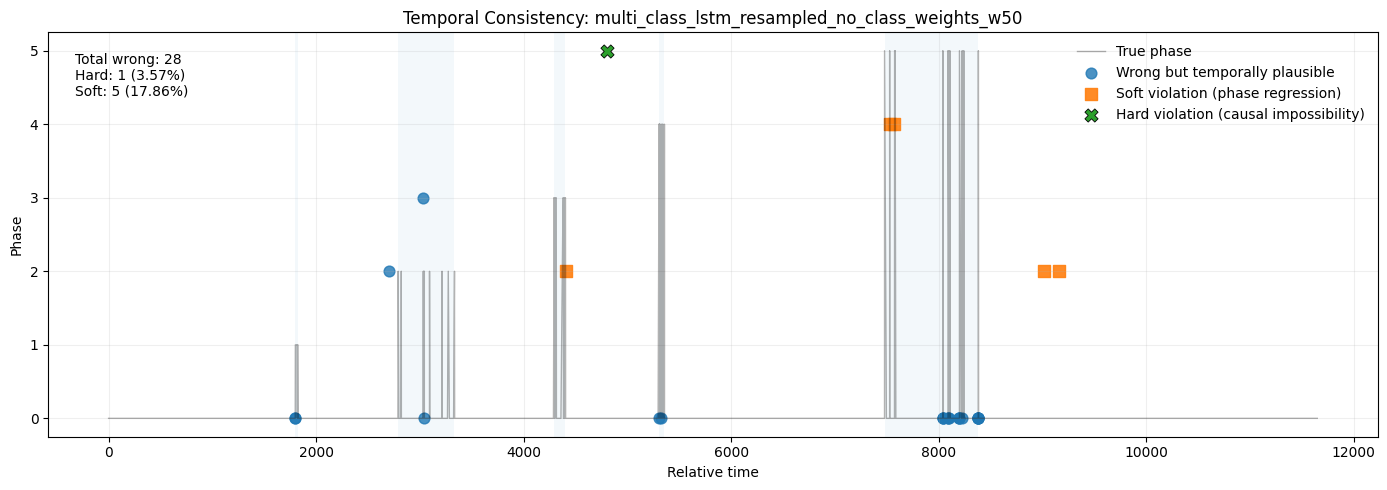

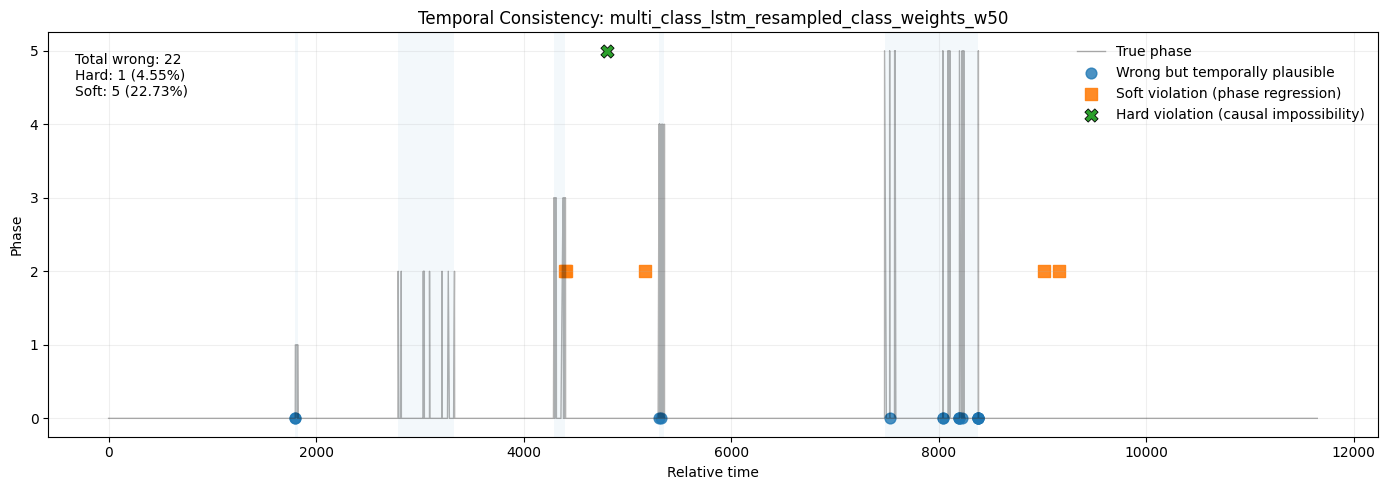

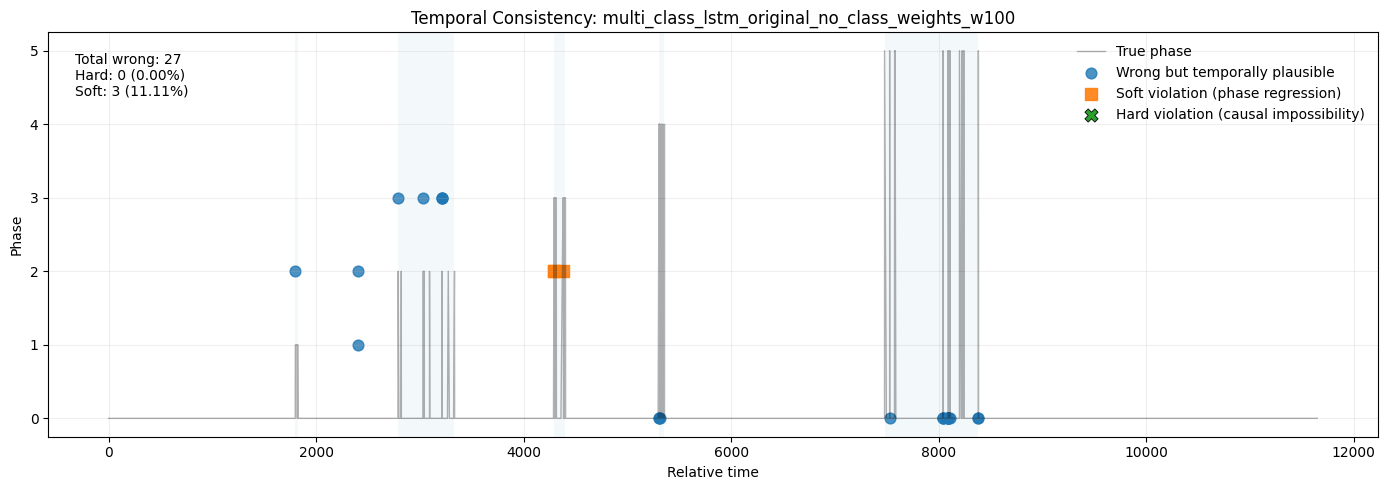

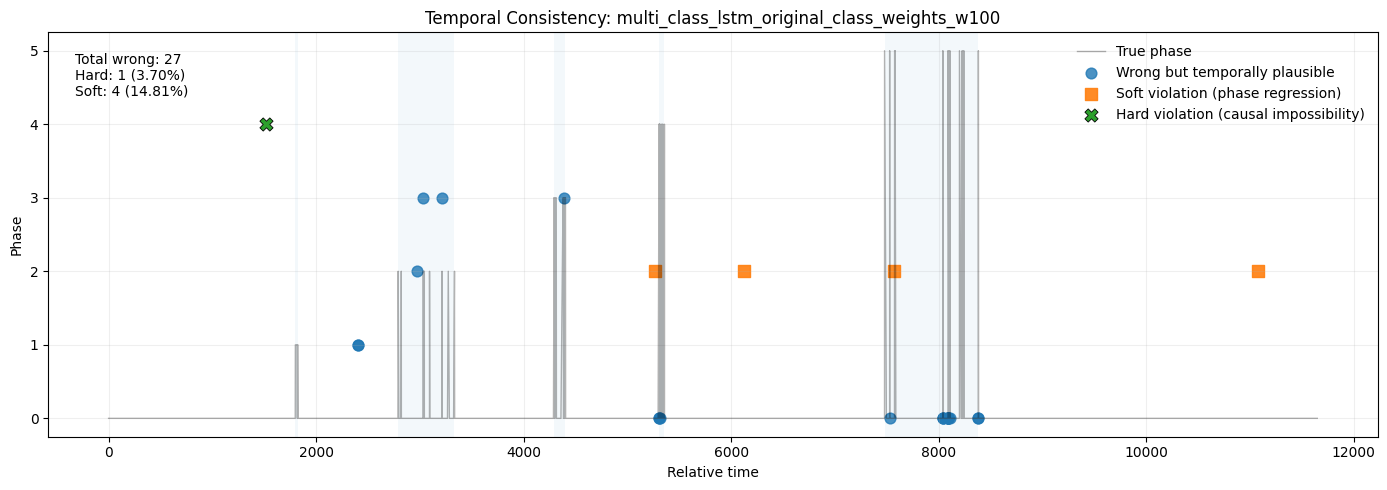

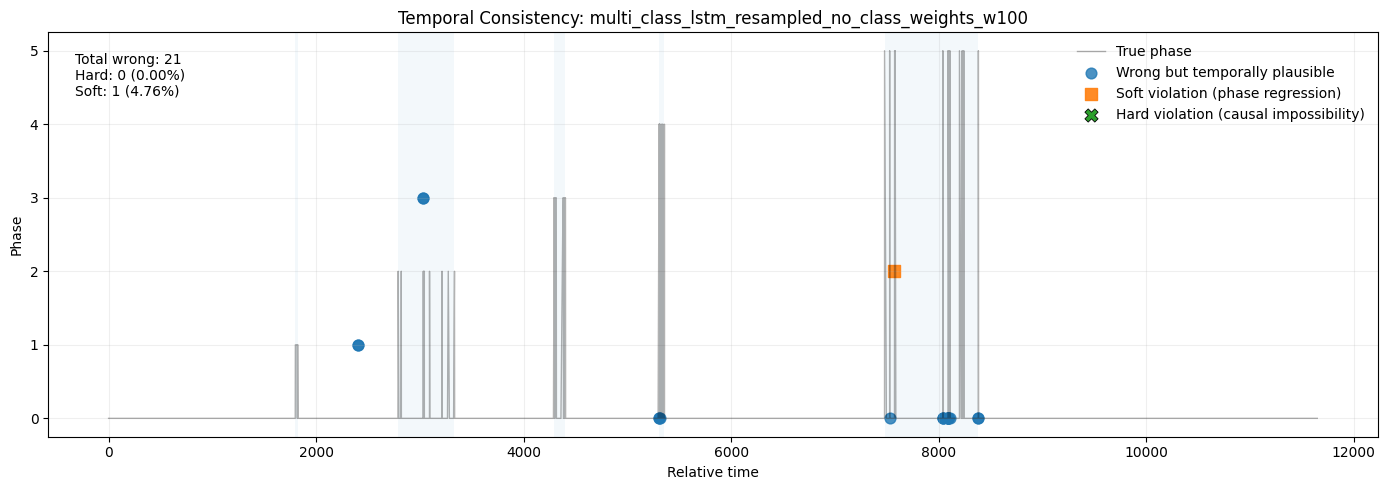

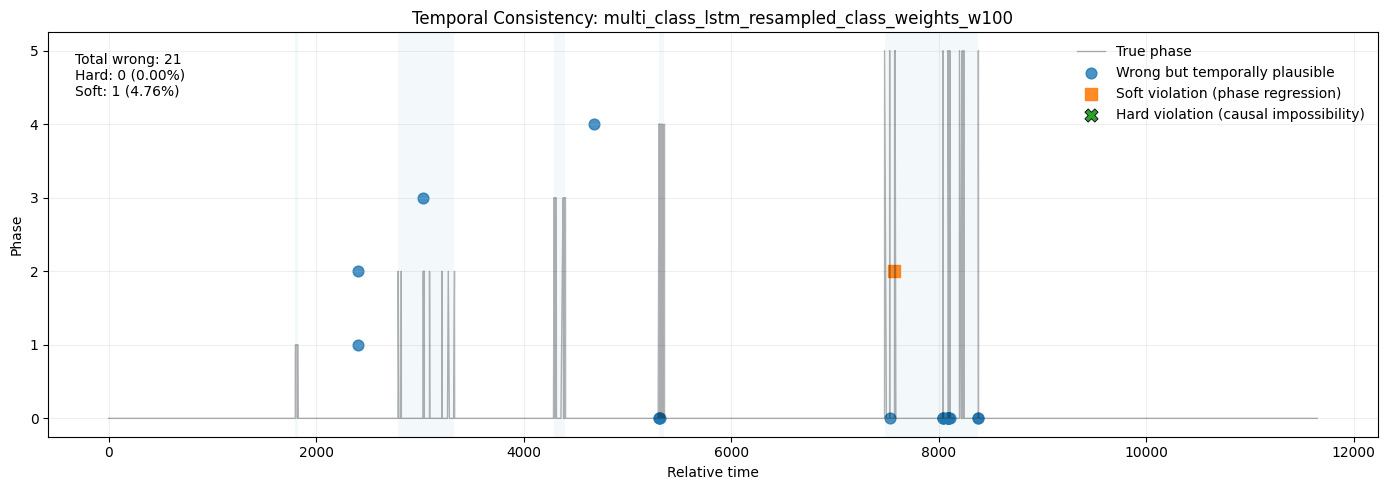

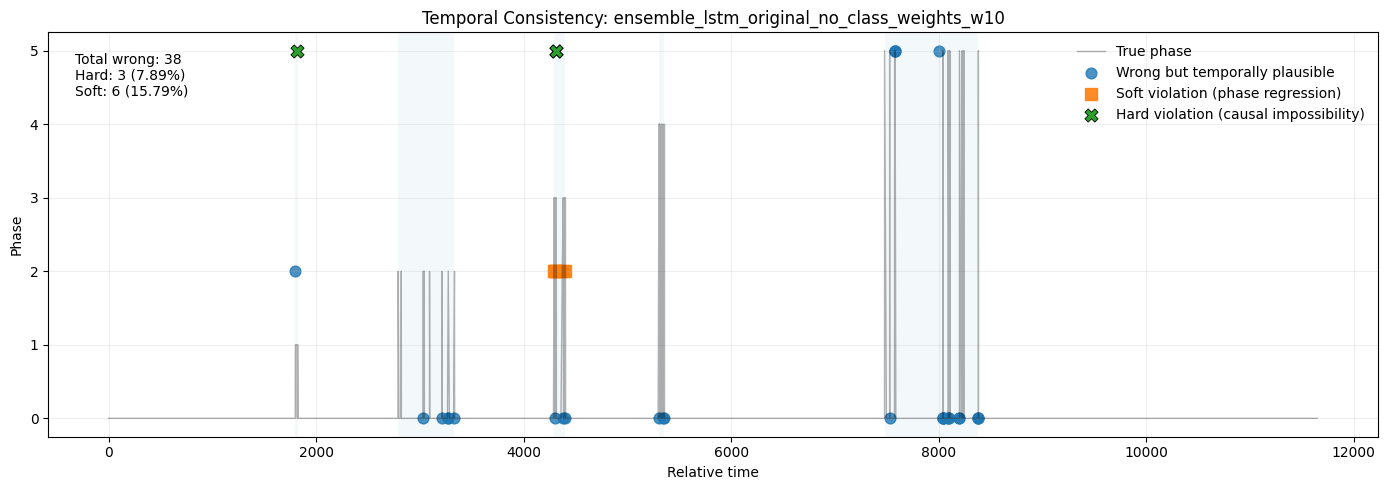

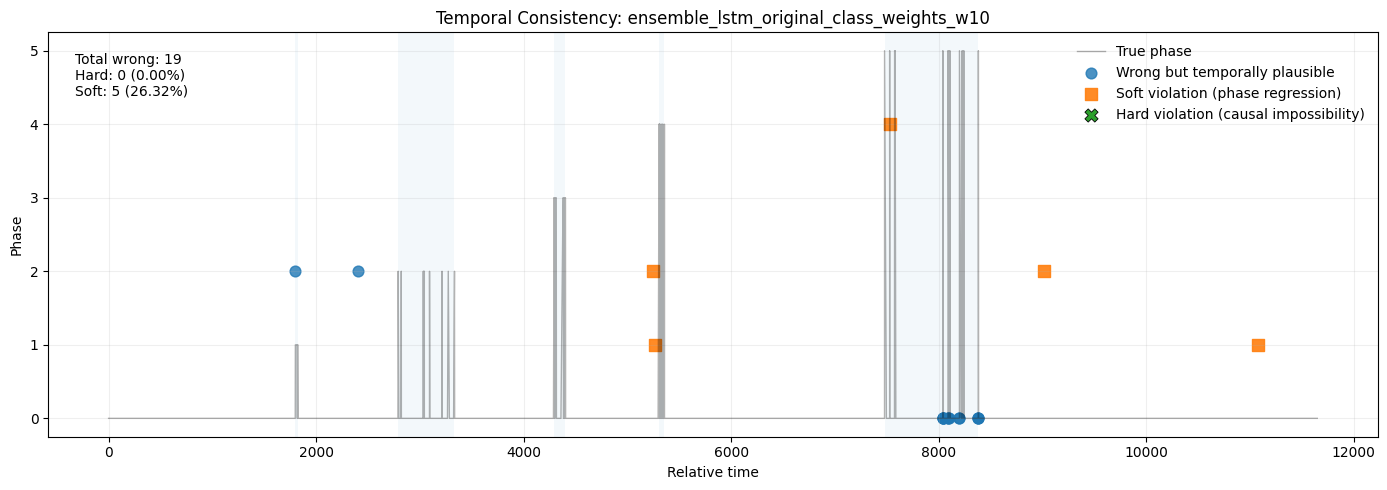

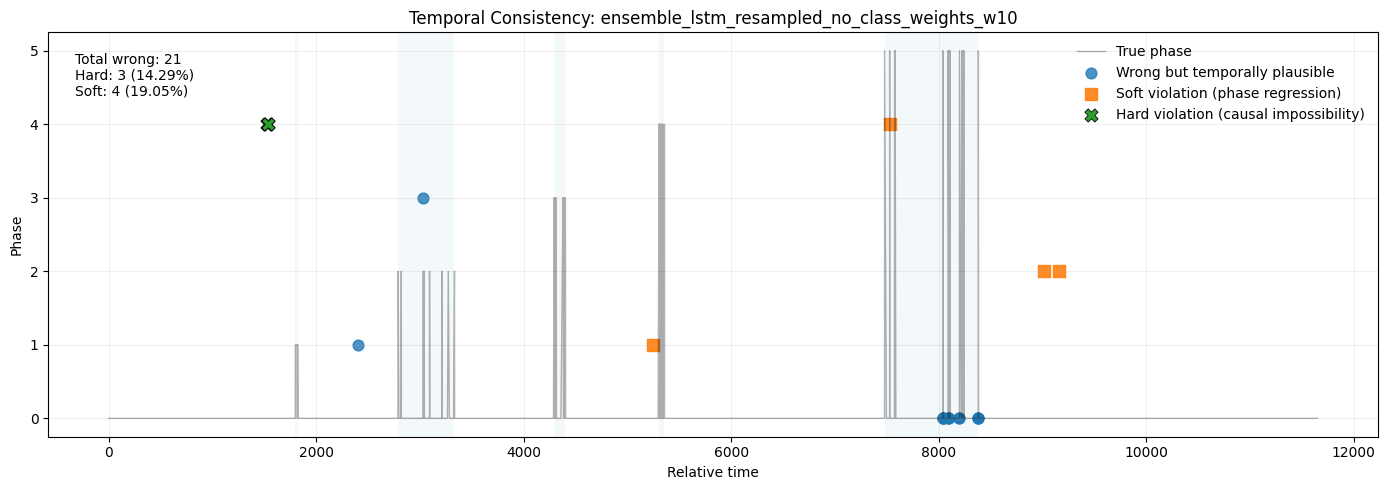

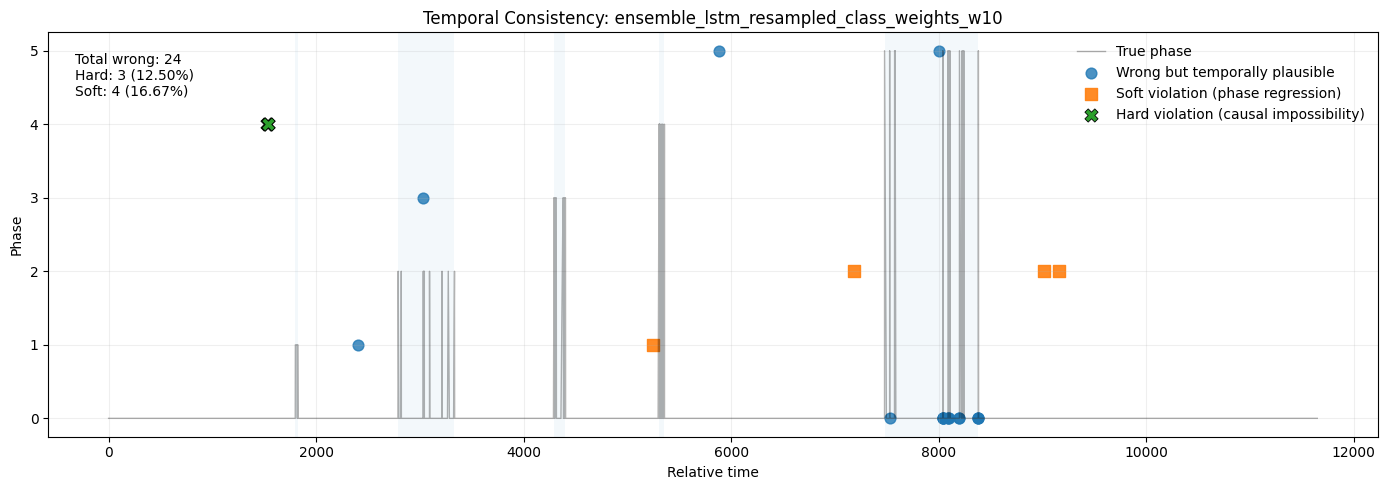

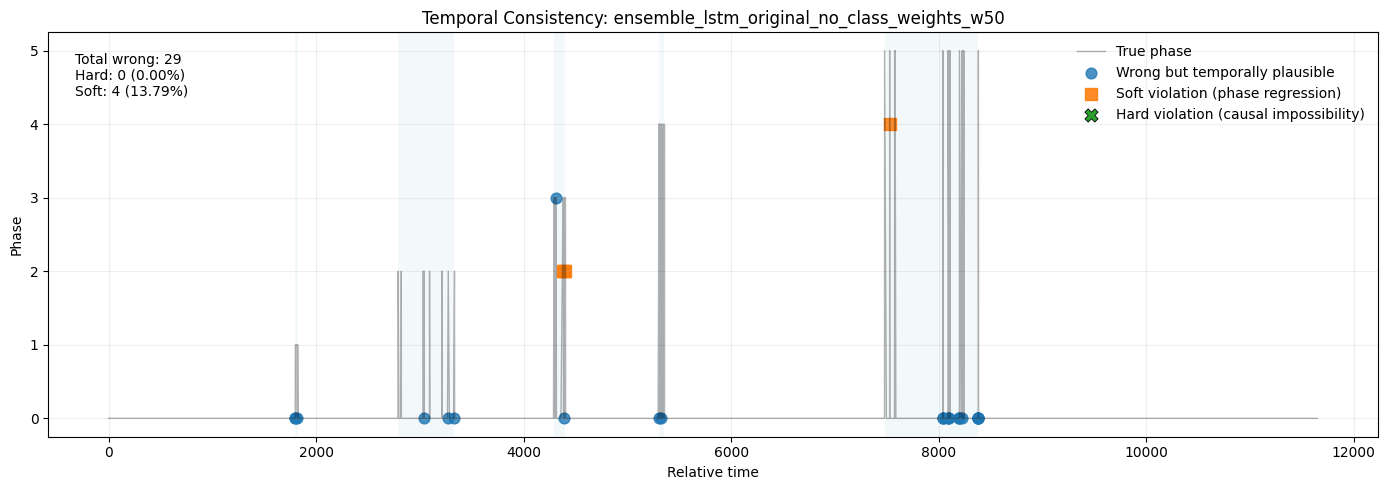

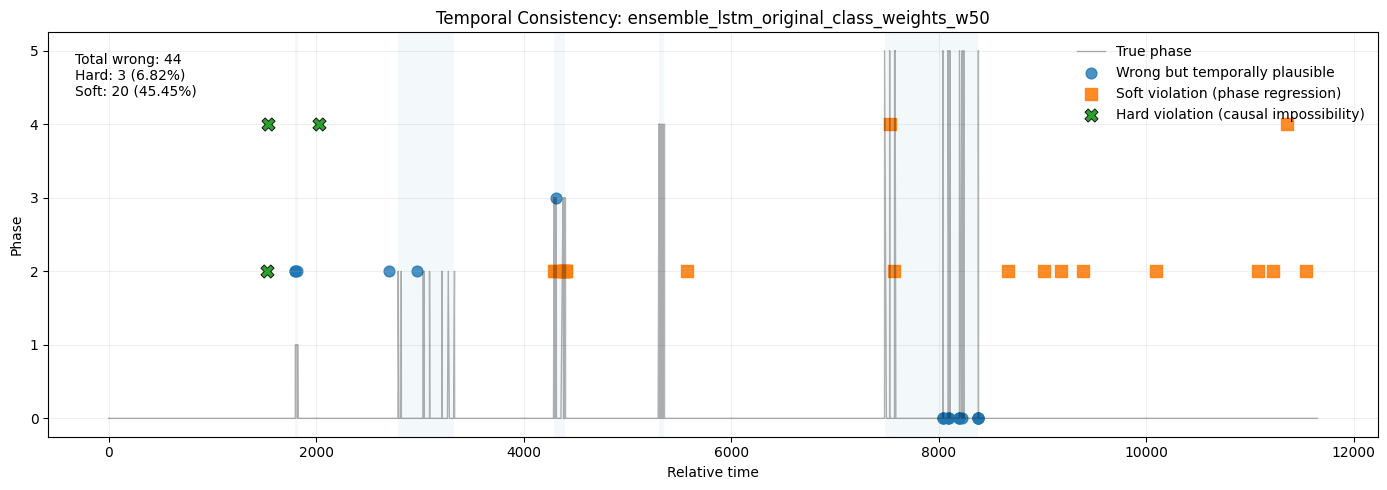

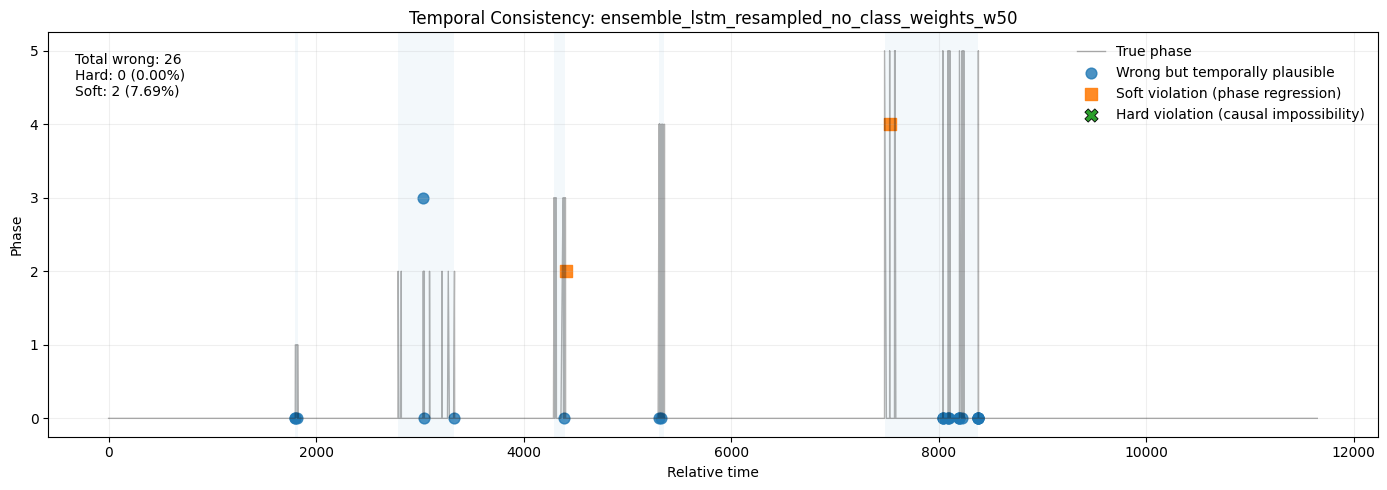

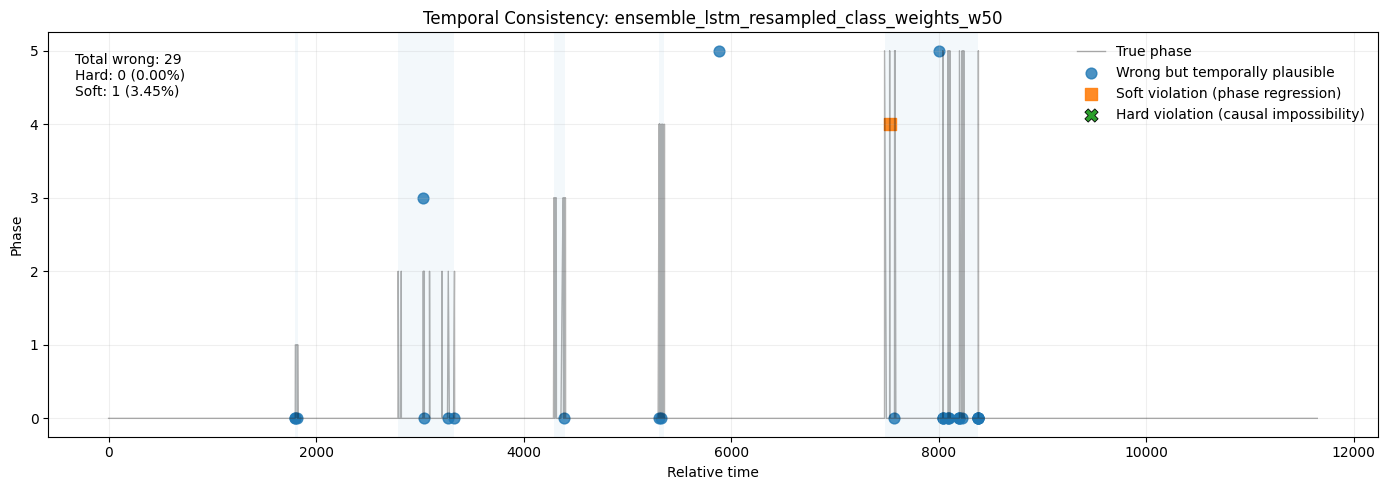

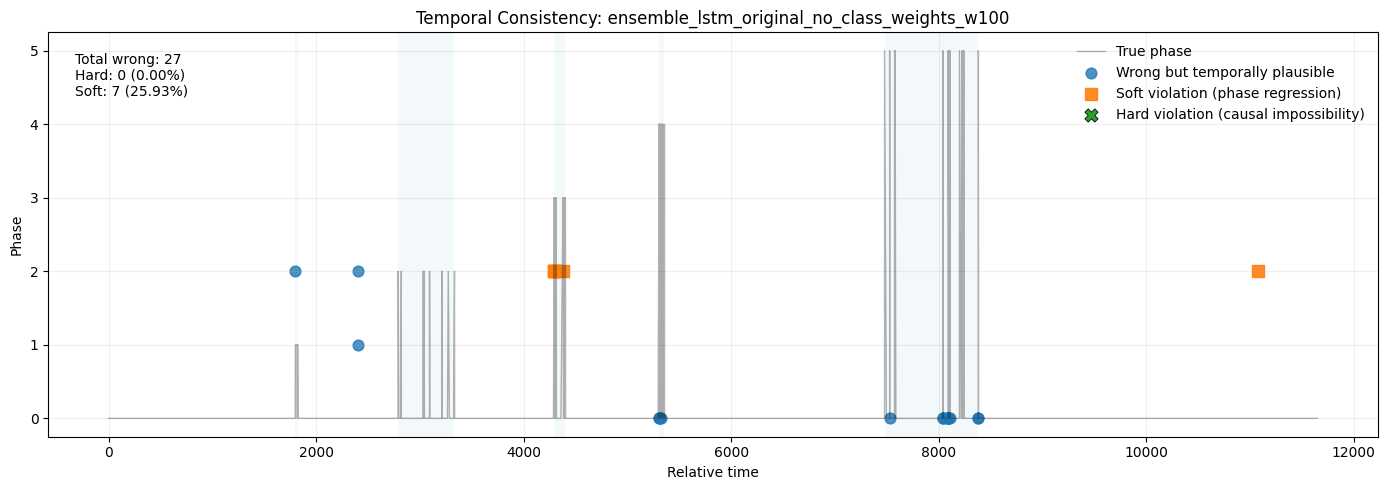

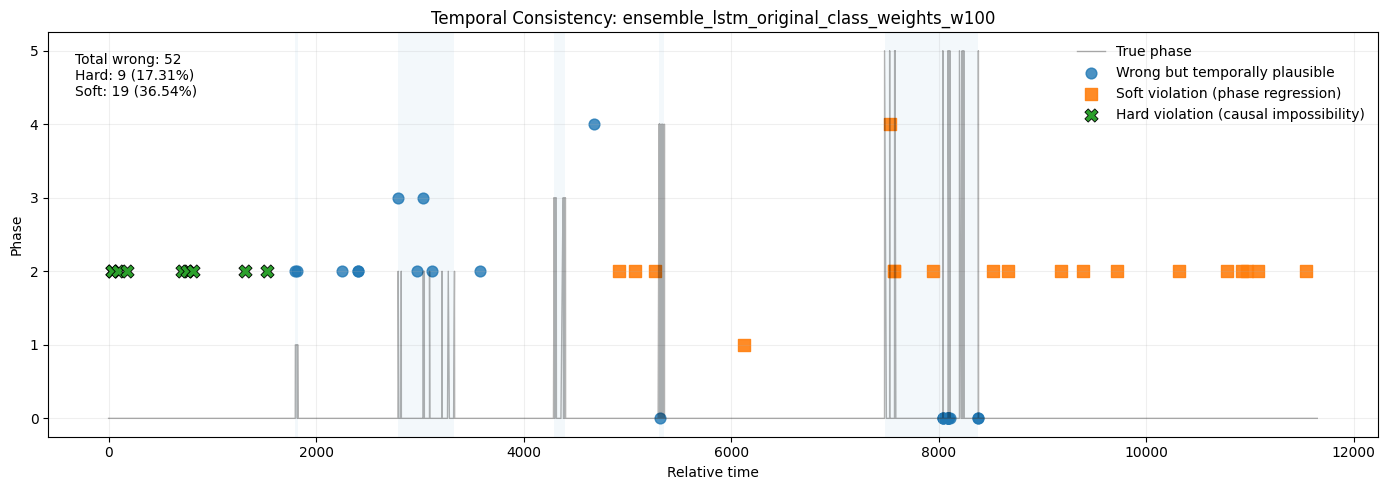

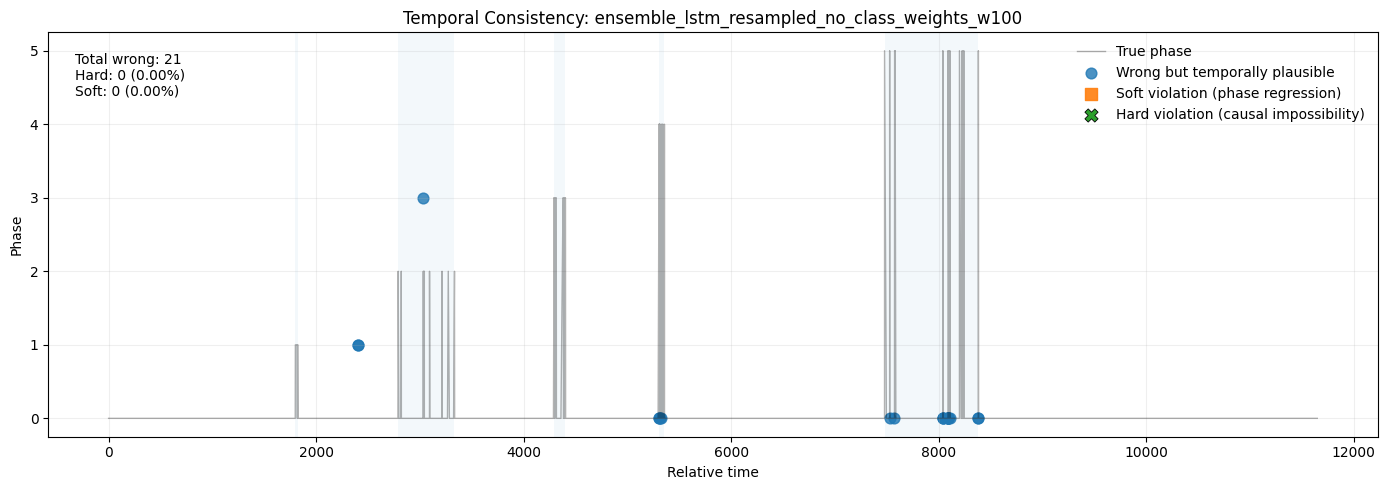

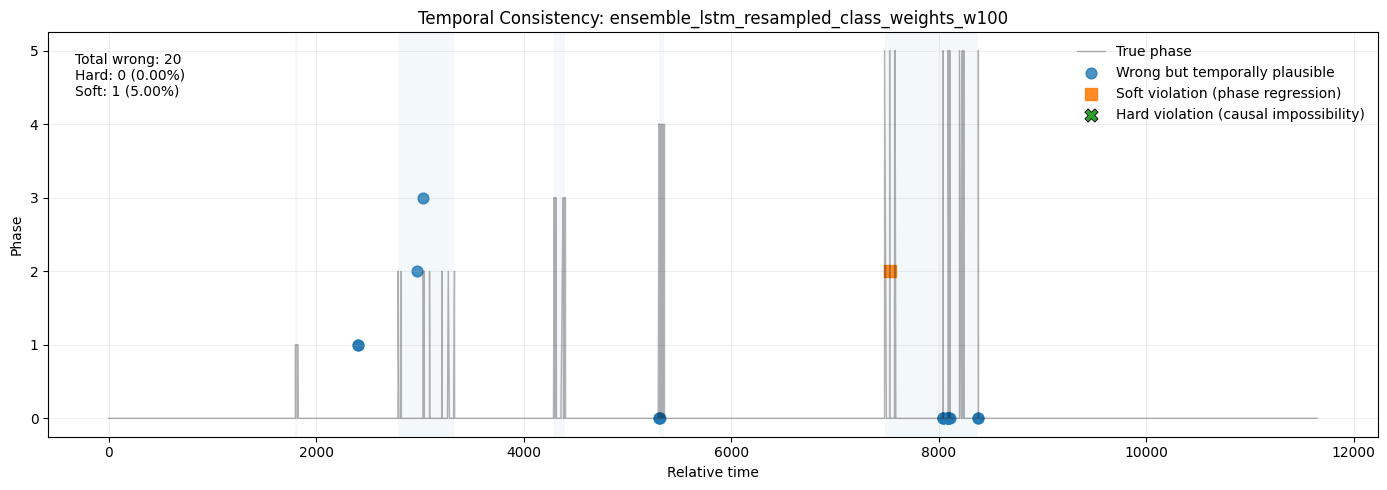

In [65]:
for model, window_size, resampled, class_weights in product(
    models,
    window_sizes,
    resampled_opts,
    class_weight_opts
):

    results_dir = f"../experiments/{dataset}/{scenario}/baselines/{model}/results"
    experiment_name = f"{model}_{resampled}_{class_weights}_w{window_size}"

    metrics_file = (
        f"{results_dir}/"
        f"{experiment_name}_metrics.json"
    )

    if not os.path.exists(metrics_file):
        print(f"Skipping missing: {metrics_file}")
        continue

    with open(metrics_file) as f:
        metrics = json.load(f)

    # --- Load misclassification info ---
    real_flow_indices = metrics["real_flow_indices"]
    mis_y_pred = metrics["y_pred"]
    mis_y_true = metrics["y_true"]

    mis_df = df.iloc[real_flow_indices].copy()
    mis_df["y_true"] = mis_y_true
    mis_df["y_pred"] = mis_y_pred

    # --- Compute violation categories ---
    wrong, hard, soft, plausible = mis_metrics(mis_df, phase_start)

    total_wrong = len(wrong)
    hard_rate = len(hard) / total_wrong if total_wrong > 0 else 0
    soft_rate = len(soft) / total_wrong if total_wrong > 0 else 0

    # --- Collect everything ---
    results.append({
        "model": f"{experiment_name}",
        "accuracy": metrics["accuracy"],
        "precision" : metrics["precision"],
        "recall" : metrics["recall"], 
        "f1": metrics["f1"],
        "total_wrong": total_wrong,
        "hard_violations": len(hard),
        "soft_violations": len(soft),
        "hard_rate": hard_rate,
        "soft_rate": soft_rate,
    })

    # Create plots

    plot_mis_predictions(df, phase_bounds, plausible, soft, hard, total_wrong, soft_rate, hard_rate, experiment_name)

In [66]:
results_df = pd.DataFrame(results)

results_df

,model,accuracy,precision,recall,f1,total_wrong,hard_violations,soft_violations,hard_rate,soft_rate
0,multi_class_lstm_original_no_class_weights_w10,0.999444,0.855404,0.772728,0.808494,28,0,5,0.000000,0.178571
1,multi_class_lstm_original_class_weights_w10,0.999444,0.792212,0.981298,0.864748,28,3,10,0.107143,0.357143
2,multi_class_lstm_resampled_no_class_weights_w10,0.999464,0.818706,0.981306,0.885239,27,4,7,0.148148,0.259259
3,multi_class_lstm_resampled_class_weights_w10,0.999523,0.828440,0.981330,0.890621,24,3,7,0.125000,0.291667
4,multi_class_lstm_original_no_class_weights_w50,0.999344,0.849190,0.861612,0.846611,33,0,8,0.000000,0.242424
5,multi_class_lstm_original_class_weights_w50,0.999304,0.824460,0.835488,0.800275,35,0,13,0.000000,0.371429
6,multi_class_lstm_resampled_no_class_weights_w50,0.999443,0.880499,0.873541,0.872674,28,1,5,0.035714,0.178571
7,multi_class_lstm_resampled_class_weights_w50,0.999563,0.940343,0.898702,0.905887,22,1,5,0.045455,0.227273
8,multi_class_lstm_original_no_class_weights_w100,0.999463,0.834363,0.779342,0.796566,27,0,3,0.000000,0.111111
9,multi_class_lstm_original_class_weights_w100,0.999463,0.834349,0.891391,0.854106,27,1,4,0.037037,0.148148


In [67]:
results_df["temporal_score"] = (
    results_df["f1"]
    - 0.5 * results_df["hard_rate"]
    - 0.2 * results_df["soft_rate"]
)

In [68]:
results_df_sorted_f1 = results_df.sort_values("f1", ascending=False)

# Save metrics to file
results_df_sorted_f1.to_csv(
    f"../reports/baselines/temporal_consistency_summary.csv",
    index=False
)

In [69]:
results_df_sorted_f1.head()

,model,accuracy,precision,recall,f1,total_wrong,hard_violations,soft_violations,hard_rate,soft_rate,temporal_score
13,ensemble_lstm_original_class_weights_w10,0.999622,0.890752,0.979053,0.929069,19,0,5,0.000000,0.263158,0.876438
15,ensemble_lstm_resampled_class_weights_w10,0.999523,0.859986,0.981328,0.912855,24,3,4,0.125000,0.166667,0.817022
14,ensemble_lstm_resampled_no_class_weights_w10,0.999583,0.861520,0.981352,0.912269,21,3,4,0.142857,0.190476,0.802745
7,multi_class_lstm_resampled_class_weights_w50,0.999563,0.940343,0.898702,0.905887,22,1,5,0.045455,0.227273,0.837706
23,ensemble_lstm_resampled_class_weights_w100,0.999602,0.922102,0.909955,0.903855,20,0,1,0.000000,0.050000,0.893855


In [70]:
results_df_sorted_temp = results_df.sort_values("temporal_score", ascending=False)

results_df_sorted_temp.head()

,model,accuracy,precision,recall,f1,total_wrong,hard_violations,soft_violations,hard_rate,soft_rate,temporal_score
22,ensemble_lstm_resampled_no_class_weights_w100,0.999582,0.955412,0.886148,0.899144,21,0,0,0.0,0.000000,0.899144
23,ensemble_lstm_resampled_class_weights_w100,0.999602,0.922102,0.909955,0.903855,20,0,1,0.0,0.050000,0.893855
11,multi_class_lstm_resampled_class_weights_w100,0.999582,0.903576,0.909950,0.902462,21,0,1,0.0,0.047619,0.892938
10,multi_class_lstm_resampled_no_class_weights_w100,0.999582,0.924872,0.891439,0.895392,21,0,1,0.0,0.047619,0.885869
13,ensemble_lstm_original_class_weights_w10,0.999622,0.890752,0.979053,0.929069,19,0,5,0.0,0.263158,0.876438


## Analyze Specific Model

In [71]:
# Hyperparameters for best-performing model
model = "multi_class_lstm"
variant = "resampled"
weights = "no_class_weights"
window_size = 10

In [72]:
processed_dir = f"../data/processed/{dataset}/{scenario}/windowed"
results_dir = f"../experiments/{dataset}/{scenario}/baselines/{model}/results"

exp_name = f"{model}_{variant}_{weights}_w{window_size}"
metrics_file = f"{results_dir}/{exp_name}_metrics.json"

In [73]:
with open(metrics_file) as f:
    metrics = json.load(f)

misclassified_indices = metrics["misclassified_indices"]
real_flow_indices = metrics["real_flow_indices"]
mis_y_pred = metrics["y_pred"]
mis_y_true = metrics["y_true"]

mis_df = df.iloc[real_flow_indices].copy()
mis_df["y_true"] = mis_y_true
mis_df["y_pred"] = mis_y_pred


In [74]:
wrong, hard, soft, plausible = mis_metrics(mis_df, phase_start)

total_wrong = len(wrong)

hard_rate = len(hard) / total_wrong if total_wrong > 0 else 0
soft_rate = len(soft) / total_wrong if total_wrong > 0 else 0

print(f"Total wrong: {total_wrong}")
print(f"Hard violations: {len(hard)} ({hard_rate:.2%})")
print(f"Soft violations: {len(soft)} ({soft_rate:.2%})")

Total wrong: 27
Hard violations: 4 (14.81%)
Soft violations: 7 (25.93%)


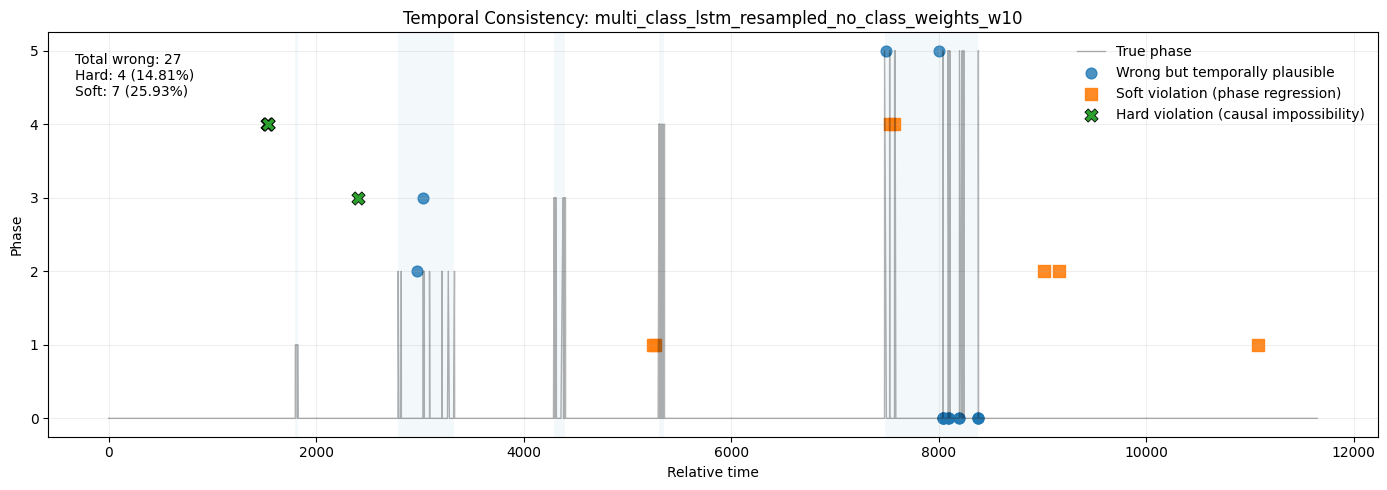

In [75]:
plot_mis_predictions(df, phase_bounds, plausible, soft, hard, total_wrong, soft_rate, hard_rate, exp_name)

In [76]:
mis_only = mis_df[mis_df["y_true"] != mis_df["y_pred"]]

pd.crosstab(
    mis_only["y_true"],
    mis_only["y_pred"],
)

y_pred,0,1,2,3,4,5
y_true,,,,,,
0,0,3,3,1,3,2
2,0,0,0,1,0,0
5,12,0,0,0,2,0


### Analyze phase 5 misclassifications

In [77]:
mis_df[mis_df['phase'] == 5]

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel,y_true,y_pred,hard_violation,soft_violation
39483,f39454,9.524464e+08,9.524464e+08,0.000658,172.16.115.20,1020,202.77.162.213,1022,tcp,-,...,2,80,-,6,5,7528.056140,5,4,False,True
39857,f40684,9.524465e+08,9.524465e+08,0.000000,8.138.161.2,4845,131.84.1.31,12277,tcp,-,...,0,0,-,6,5,7574.669127,5,4,False,True
114608,f114583,9.524469e+08,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,9,6530,-,6,5,8040.431538,5,0,False,False
114612,f114585,9.524469e+08,9.524469e+08,0.078284,172.16.115.5,22956,131.84.1.31,80,tcp,http,...,12,14998,-,6,5,8040.584752,5,0,False,False
114614,f114586,9.524469e+08,9.524469e+08,0.042209,172.16.115.5,23020,131.84.1.31,80,tcp,http,...,6,5082,-,6,5,8040.665718,5,0,False,False
114616,f114587,9.524469e+08,9.524469e+08,0.053722,172.16.115.5,23083,131.84.1.31,80,tcp,http,...,9,6321,-,6,5,8040.710396,5,0,False,False
114647,f114621,9.524470e+08,9.524470e+08,0.030979,172.16.116.201,23464,131.84.1.31,80,tcp,http,...,4,2432,-,6,5,8090.326437,5,0,False,False
114655,f114626,9.524470e+08,9.524470e+08,0.050499,172.16.116.201,23655,131.84.1.31,80,tcp,http,...,6,5082,-,6,5,8090.608249,5,0,False,False
114661,f114640,9.524470e+08,9.524470e+08,0.050664,172.16.115.5,23782,131.84.1.31,80,tcp,http,...,8,7992,-,6,5,8103.255592,5,0,False,False
115033,f115007,9.524471e+08,9.524471e+08,0.078300,172.16.115.5,24713,131.84.1.31,80,tcp,http,...,9,7092,-,6,5,8200.677959,5,0,False,False


In [78]:
start_index = 114603
indices = range(start_index, start_index+20)
df_filtered = df.iloc[indices]
df_filtered

,flow_id,start_time,end_time,duration,src_ip,sport,dst_ip,dport,proto,service,...,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,ip_proto,phase,t_rel
114603,f114588,9.524469e+08,9.524469e+08,0.001050,172.16.115.5,1078,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.333211
114604,f114581,9.524469e+08,9.524469e+08,0.052330,172.16.115.5,22702,131.84.1.31,80,tcp,http,...,0,ShADdfFa,6,501,6,4445,-,6,5,8040.335196
114605,f114589,9.524469e+08,9.524469e+08,0.000779,172.16.115.5,1079,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.395936
114606,f114582,9.524469e+08,9.524469e+08,0.031471,172.16.115.5,22766,131.84.1.31,80,tcp,http,...,0,ShADdfFa,5,511,4,2432,-,6,5,8040.397506
114607,f114590,9.524469e+08,9.524469e+08,0.000779,172.16.115.5,1080,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.430035
114608,f114583,9.524469e+08,9.524469e+08,0.052641,172.16.115.5,22829,131.84.1.31,80,tcp,http,...,0,ShADadfF,7,581,9,6530,-,6,5,8040.431538
114609,f114591,9.524469e+08,9.524469e+08,0.000839,172.16.115.5,1081,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.485207
114610,f114584,9.524469e+08,9.524469e+08,0.095386,172.16.115.5,22893,131.84.1.31,80,tcp,http,...,0,ShADadfF,11,756,18,21837,-,6,5,8040.486750
114611,f114592,9.524469e+08,9.524469e+08,0.000778,172.16.115.5,1082,172.16.115.20,53,udp,dns,...,0,Dd,1,56,1,116,-,17,0,8040.583206
114612,f114585,9.524469e+08,9.524469e+08,0.078284,172.16.115.5,22956,131.84.1.31,80,tcp,http,...,0,ShADdfFa,9,659,12,14998,-,6,5,8040.584752


In [79]:
dst_ip = "131.84.1.31"
df_filtered_dst_ip = df[df["dst_ip"] == dst_ip]

phase_counts = df_filtered_dst_ip["phase"].value_counts().sort_index()
phase_counts

phase
0        7
5    73443
Name: count, dtype: int64